In [1]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
import logging
import torch.nn.functional as F
logging.basicConfig(level=logging.ERROR)

In [2]:
!pip install torchviz
from torchviz import make_dot

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=95e8b9411839e90e1f7278c81893f7c59c676c1bdc1c8ed356e373d5eaf3cdf7
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [3]:
dataset = pd.read_csv('/kaggle/input/subtasks-dataset/0 CHIPSAL@COLING 2025/C/SubTask-C-train.csv', delimiter=',')
val_dataset_text = pd.read_csv('/kaggle/input/subtasks-dataset/0 CHIPSAL@COLING 2025/C/SubTask-C-(indextweet)val.csv', delimiter=',')
val_dataset_label = pd.read_csv('/kaggle/input/subtasks-dataset/0 CHIPSAL@COLING 2025/C/SubTask-C-(indexlabel)val.csv')
#test_dataset_text = pd.read_csv('/kaggle/input/subtasks-dataset/0 CHIPSAL@COLING 2025/A/Task-A(indextext)val.csv', delimiter=',')
#test_dataset_label = pd.read_csv('/kaggle/input/subtasks-dataset/0 CHIPSAL@COLING 2025/A/Task-A(indexlabel)val.csv')

In [4]:
val_dataset = val_dataset_text.join(val_dataset_label['label'])
val_dataset

# test_dataset = test_dataset_text.join(test_dataset_label['label'])
# test_dataset


,index,tweet,label
0,50012,भोट त लौरोमा हाल्ने हो रुखमा त मल हाले हुन्छ ।,1
1,50025,केन्द्रीय गृह एवं सहकारिता मंत्री अमित शाह (@A...,0
2,50027,@Alive_Aleeza @bishwaprakash77 @kpsharmaoli वि...,0
3,50028,"@cmprachanda, @ncp_madhavnepal , @SherBDeuba ,...",0
4,50029,महाविद्ध्वान खड्ग प्रसादलाई भोट दिने भनेको जोक...,0
...,...,...,...
469,53142,माओवादीद्वारा रूकुमपूर्वमा एमाले कार्यकर्ताको ...,1
470,53143,@myogiadityanath मालेगाँव विस्फोटमें कौन शामिल...,0
471,53151,मुसो: नेपाली जनता\nबिरालो: ठूला दलका नेता\n\n#...,2
472,53161,"कांग्रेस,एमाले र माओवादीलाई ३०वर्षसम्म लगातार ...",1


In [5]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [6]:
train = dataset[['tweet','label']]
val = val_dataset[['tweet','label']]
#test = test_dataset[['text','label']]
print(train)
print(val)

                                                  tweet  label
0     @me_sherya सक्छ। यो जाबो एमाले त मलाई मनै पर्दैन।      1
1     ‘धार्मिक भावनाएँ भड़का कर दंगे करवाना चाहते है...      0
2     @belakoboli ये ट्वाके अङ्कल ओलि देउवा  माकुने ...      0
3     @suvashsanatani यिनिहरुले बाटो, पुल, स्कुल, बि...      2
4     हिजो पार्टी मा ओलिले एकलौटि गर्‍यो भनेर स्याल ...      0
...                                                 ...    ...
2209  काठमाडौंको फोहोर व्यवस्थापनमा ठुलो दलको प्रत्य...      1
2210  @bishwaprakash77 आत्मसमिक्षा गर्ने तपाईं ,गगन ...      0
2211  @peshru143 त्यता यसै नि एमाले हैनन र पैला ? मा...      1
2212  यी काङ्ग्रेसका नेताकाे पारा देख्दा \nमानाै यस्...      1
2213  #Rashtravad: 'अकाली दल से पंजाब के लोग नफरत कर...      1

[2214 rows x 2 columns]
                                                 tweet  label
0       भोट त लौरोमा हाल्ने हो रुखमा त मल हाले हुन्छ ।      1
1    केन्द्रीय गृह एवं सहकारिता मंत्री अमित शाह (@A...      0
2    @Alive_Aleeza @bishwaprakash

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, average_precision_score, roc_curve, precision_recall_curve

def calculate_metrics(df):
    # Extracting Predicted and True labels
    y_pred = df['Predicted']
    y_true = df['True']

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate precision, recall, F1-score for each class
    precision = precision_score(y_true, y_pred,average='weighted')
    recall = recall_score(y_true, y_pred,average='weighted')
    f1 = f1_score(y_true, y_pred,average='weighted')

    # Calculate micro-average precision, recall, F1-score
    micro_precision = precision_score(y_true, y_pred, average='micro')
    micro_recall = recall_score(y_true, y_pred, average='micro')
    micro_f1 = f1_score(y_true, y_pred, average='micro')

    # Calculate macro-average precision, recall, F1-score
    macro_precision = precision_score(y_true, y_pred, average='macro')
    macro_recall = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
        
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Micro Precision:", micro_precision)
    print("Micro Recall:", micro_recall)
    print("Micro F1 Score:", micro_f1)
    print("Macro Precision:", macro_precision)
    print("Macro Recall:", macro_recall)
    print("Macro F1 Score:", macro_f1)

In [ ]:

MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4

LEARNING_RATE = 1e-05

tokenizer = AutoTokenizer.from_pretrained("ibm/ia-multilingual-transliterated-roberta", trunctation = True)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.07M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [9]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.tweet
        self.targets = self.data.label.astype(int)
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [10]:
val_data=val.copy()
train_data = train.copy()
#stest_data = test.copy()


print("TRAIN Dataset: {}".format(train_data.shape))
print("VAL Dataset: {}".format(val_data.shape))
#print("STEST Dataset: {}".format(stest_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN)
validation_set = SentimentData(val_data, tokenizer, MAX_LEN)
#stesting_set = SentimentData(stest_data, tokenizer, MAX_LEN)

TRAIN Dataset: (2214, 2)
VAL Dataset: (474, 2)


In [11]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }
# stest_params = {'batch_size': VALID_BATCH_SIZE,
#                 'shuffle': False,
#                 'num_workers': 0
#                 }

training_loader = DataLoader(training_set, **train_params)
validating_loader = DataLoader(validation_set, **val_params)
# stesting_loader = DataLoader(stesting_set, **stest_params)

In [12]:
class MultilingualRobertaClass(torch.nn.Module):
    def __init__(self):
        super(MultilingualRobertaClass, self).__init__()
        self.l1 = AutoModel.from_pretrained("ibm/ia-multilingual-transliterated-roberta")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 3)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        #output = torch.argmax(output, dim = 1)
        return output

In [13]:
model = MultilingualRobertaClass()
model.to(device)

pytorch_model.bin:   0%|          | 0.00/685M [00:00<?, ?B/s]

MultilingualRobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(110000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm)

In [ ]:
# loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [15]:
# ensure that the raw logits form the model are converted to indices by applying
# argmax on the output
# preds = torch.argmax(outputs, dim = 1)
def calcuate_accuracy(outputs, targets):
    preds = torch.argmax(outputs, dim = 1)
    n_correct = (preds==targets).sum().item()
    return n_correct

# def calcuate_accuracy(preds, targets):
#     # Convert predictions to binary values (0 or 1)
#     preds_binary = (preds > 0.5).float()
#     # Calculate the number of correct predictions
#     n_correct = (preds_binary == targets.view(-1, 1)).sum().item()  # Reshape targets to match the shape of preds_binary
    
#     return n_correct

In [16]:
# # Defining the training function on the 80% of the dataset for tuning the distilbert model

# def train(epoch):
#     tr_loss = 0
#     n_correct = 0
#     nb_tr_steps = 0
#     nb_tr_examples = 0
#     model.train()
#     for _,data in tqdm(enumerate(training_loader, 0)):
#         ids = data['ids'].to(device, dtype = torch.long)
#         mask = data['mask'].to(device, dtype = torch.long)
#         token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
#         targets = data['targets'].to(device, dtype = torch.long)

#         outputs = model(ids, mask, token_type_ids)
#         # squeeze the layer for evaluation
#         targetss = targets.view(-1)
#         loss = loss_function(outputs, targetss)
#         tr_loss += loss.item()
#         correct_batch = calcuate_accuracy(outputs, targets)
#         n_correct += correct_batch

#         nb_tr_steps += 1
#         nb_tr_examples+=targets.size(0)
        
#         if _%5000==0:
#             loss_step = tr_loss/nb_tr_steps
#             accu_step = (n_correct*100)/nb_tr_examples 
#             print(f"Training Loss per 5000 steps: {loss_step}")
#             print(f"Training Accuracy per 5000 steps: {accu_step}")

#         optimizer.zero_grad()
#         loss.backward()
#         # # When using GPU
#         optimizer.step()

#     print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
#     epoch_loss = tr_loss/nb_tr_steps
#     epoch_accu = (n_correct*100)/nb_tr_examples
#     print(f"Training Loss Epoch: {epoch_loss}")
#     print(f"Training Accuracy Epoch: {epoch_accu}")

#     return outputs, model

In [ ]:
#fix 2:
import torch.nn as nn

loss_function = nn.CrossEntropyLoss()

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for step, data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.long)  # longtens fr compatibility

        outputs = model(ids, mask, token_type_ids)

        # No need to squeeze or convert to float for CrossEntropy
        loss = loss_function(outputs, targets)  

        tr_loss += loss.item()
        correct_batch = calcuate_accuracy(outputs, targets)  
        n_correct += correct_batch

        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)
        
        if step % 5000 == 0:
            loss_step = tr_loss / nb_tr_steps
            accu_step = (n_correct * 100) / nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct * 100) / nb_tr_examples}')
    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return outputs, model


In [18]:
def valid(model, testing_loader, epoch):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    res_p_l=[]
#     res_pb_l=[]
    res_t_l=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
#             targetss = targets.view(-1)
#             outputss = outputs.view(-1)
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            
            correct_batch = calcuate_accuracy(outputs, targets)
            
            n_correct += correct_batch
            
            #preds_binary = (outputs > 0.5).float()
            
            
            res_p_l.append(outputs.cpu().tolist())
#             res_pb_l.append(preds_binary.cpu().tolist())
            res_t_l.append(targets.cpu().tolist())

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
#     predicted_all  = [item[0] for sublist in res_p_l for item in sublist]
# #     predicted_b_all  = [item[0] for sublist in res_pb_l for item in sublist]
#     true_all = [item[0] for sublist in res_t_l for item in sublist]
    
#     df_sub=pd.DataFrame({'Predicted Prob':predicted_all, 'True':true_all})
#     df_sub.to_csv("Outputs"+str(epoch)+".csv",index=False)
    
#    calculate_metrics(df_sub)
    
    return epoch_accu

In [19]:
def test(model, stesting_loader, epoch):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0; tr_loss=0; nb_tr_steps=0; nb_tr_examples=0
    res_p_l=[]
#     res_pb_l=[]
    res_t_l=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask, token_type_ids)
#             targetss = targets.view(-1)
#             outputss = outputs.view(-1)
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            
            correct_batch = calcuate_accuracy(outputs, targets)
            
            n_correct += correct_batch
            
            #preds_binary = (outputs > 0.5).float()
            
            
            res_p_l.append(outputs.cpu().tolist())
#             res_pb_l.append(preds_binary.cpu().tolist())
            res_t_l.append(targets.cpu().tolist())

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Test Loss Epoch: {epoch_loss}")
    print(f"Test Accuracy Epoch: {epoch_accu}")
    
#     predicted_all  = [item[0] for sublist in res_p_l for item in sublist]
# #     predicted_b_all  = [item[0] for sublist in res_pb_l for item in sublist]
#     true_all = [item[0] for sublist in res_t_l for item in sublist]
    
#     df_sub=pd.DataFrame({'Predicted Prob':predicted_all, 'True':true_all})
#     df_sub.to_csv("Outputs"+str(epoch)+".csv",index=False)
    
#    calculate_metrics(df_sub)
    
    return epoch_accu

In [20]:
def save_model(epoch):
    output_model_file = 'pytorch_IA_Multilingual_roberta_'+str(epoch)+'_TaskC.bin'
    output_vocab_file = './'

    model_to_save = model
    torch.save(model_to_save, output_model_file)

In [21]:
EPOCHS = 5
for epoch in range(1,EPOCHS+1):
    print ("==============================\nEpoch: ",epoch,"\n===========================")
    y,model = train(epoch)
    valid(model, validating_loader, epoch)
    #test(model, stesting_loader, epoch)
    #save_model(epoch)
    make_dot(y.mean(), params=dict(model.named_parameters()))

Epoch:  1 


0it [00:00, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Training Loss per 5000 steps: 1.000826120376587
Training Accuracy per 5000 steps: 37.5


277it [00:58,  4.73it/s]


The Total Accuracy for Epoch 1: 60.704607046070464
Training Loss Epoch: 0.8700261499046849
Training Accuracy Epoch: 60.704607046070464


119it [00:04, 26.35it/s]


Validation Loss Epoch: 0.6877642231328147
Validation Accuracy Epoch: 71.30801687763713
Epoch:  2 


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.8477856516838074
Training Accuracy per 5000 steps: 75.0


277it [00:58,  4.77it/s]


The Total Accuracy for Epoch 2: 73.66757000903343
Training Loss Epoch: 0.6594769170891077
Training Accuracy Epoch: 73.66757000903343


119it [00:04, 26.41it/s]


Validation Loss Epoch: 0.7143177942318075
Validation Accuracy Epoch: 71.72995780590718
Epoch:  3 


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.31634703278541565
Training Accuracy per 5000 steps: 100.0


277it [00:58,  4.76it/s]


The Total Accuracy for Epoch 3: 81.79765130984643
Training Loss Epoch: 0.46974111808336166
Training Accuracy Epoch: 81.79765130984643


119it [00:04, 26.50it/s]


Validation Loss Epoch: 0.7413674206355539
Validation Accuracy Epoch: 73.41772151898734
Epoch:  4 


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.14561060070991516
Training Accuracy per 5000 steps: 100.0


277it [00:58,  4.77it/s]


The Total Accuracy for Epoch 4: 90.51490514905149
Training Loss Epoch: 0.28336576460474017
Training Accuracy Epoch: 90.51490514905149


119it [00:04, 26.44it/s]


Validation Loss Epoch: 0.8888438918134746
Validation Accuracy Epoch: 71.94092827004219
Epoch:  5 


0it [00:00, ?it/s]

Training Loss per 5000 steps: 0.11263035237789154
Training Accuracy per 5000 steps: 100.0


277it [00:58,  4.77it/s]


The Total Accuracy for Epoch 5: 95.6639566395664
Training Loss Epoch: 0.1643171773093756
Training Accuracy Epoch: 95.6639566395664


119it [00:04, 26.31it/s]

Validation Loss Epoch: 1.0055936762609152
Validation Accuracy Epoch: 73.20675105485232


In [22]:
save_model(EPOCHS)

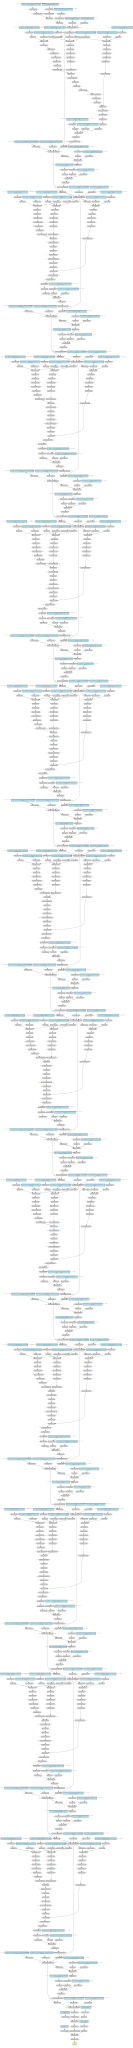

In [23]:
make_dot(y.mean(), params=dict(model.named_parameters()))

In [24]:
tokenizer.save_vocabulary('./')

('./vocab.json', './merges.txt')